Для первичной обработки данных будем пользоваться библиотекой pandas

In [49]:
import pandas as pd
import csv
data = pd.read_csv("rfm.tsv", quoting=csv.QUOTE_NONE, sep="\t",
                   names=["timestamp", "user_id", "url or click", "geo_id", "category", "price"])
data.tail()

,timestamp,user_id,url or click,geo_id,category,price
10007142,1361889766,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,213,4165204,NaN
10007143,1361889775,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,213,4165204,NaN
10007144,1361889674,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981213&hid=294661&hyperid=...,213,294661,NaN
10007145,1361889363,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,213,91033,NaN
10007146,1361889367,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,213,91033,NaN


Сколько всего пользователей в базе?

In [50]:
n_users = data.user_id.nunique()
n_users

299208

Сколько всего кликов в базе?

In [51]:
n_clicks = len(data)
n_clicks

10007147

Заменим NaN в колонке price на 0

In [52]:
data["price"] = data["price"].fillna(0)
data.tail()

,timestamp,user_id,url or click,geo_id,category,price
10007142,1361889766,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,213,4165204,0.0
10007143,1361889775,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,213,4165204,0.0
10007144,1361889674,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981213&hid=294661&hyperid=...,213,294661,0.0
10007145,1361889363,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,213,91033,0.0
10007146,1361889367,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,213,91033,0.0


Сохраним исходную таблицу, чтобы поработать только с некоторыми столбцами

In [53]:
rfm = data

In [54]:
rfm.drop(["geo_id", "category"], axis=1, inplace=True)
rfm.tail()

,timestamp,user_id,url or click,price
10007142,1361889766,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,0.0
10007143,1361889775,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,0.0
10007144,1361889674,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981213&hid=294661&hyperid=...,0.0
10007145,1361889363,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,0.0
10007146,1361889367,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,0.0


In [55]:
import datetime
print datetime.datetime.fromtimestamp(rfm["timestamp"].min())
print datetime.datetime.fromtimestamp(rfm["timestamp"].max())

2013-01-01 00:00:53
2013-12-31 23:58:37


Самый поздний клик - почти перед Новым годом, поэтому будем считать frequency, начиная от 1 января 2014 года.

In [56]:
today = datetime.datetime(2014, 1, 1)

rfm.rename(columns={"timestamp":"recency", "url or click":"frequency", "price":"money"}, inplace=True)
rfm = rfm.groupby("user_id").agg({"recency": lambda x: (today - datetime.datetime.fromtimestamp(x.max())).days, 
                                  "frequency": lambda x: len(x), "money": lambda x: x.sum()}) 

rfm.tail()

,money,frequency,recency
user_id,,,
ffff32de00441b07411d25b7c3adc8cc,0.0,1,46
ffffb9390285f56b4691aed5e3879663,0.0,37,194
ffffd6bd3a3f1e7b3b92a790104a6ae4,263.0,132,267
ffffda42ccd5f1ed15a700b23fc6c8e5,16.0,2,328
fffffdbc5c7fbe34b444d9c213bba286,0.0,25,308


Посчитаем, сколько пользователей совершили последнее действие в зависимости от месяца и построим график

In [57]:
from collections import Counter, defaultdict
recency_counter = Counter(rfm["recency"])

by_months = dict.fromkeys(range(12), 0)

for i in range(360):
    by_months[i / 30] += recency_counter[i]
    
for i in range(360, 365):
    by_months[11] += recency_counter[i]

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


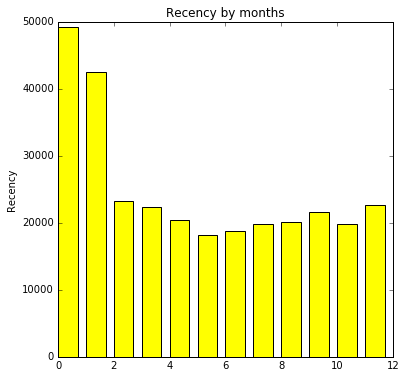

In [58]:
import pylab as pl
%pylab inline

pl.figure(figsize=(6,6))
pl.bar(by_months.keys(), by_months.values(), width = 0.7, color = "yellow")
#pl.xticks(by_months.keys())
pl.ylabel("Recency")
pl.title("Recency by months")
pl.show()

Посчитаем квантили, чтобы найти разбиение на классы

In [59]:
quantiles = rfm.quantile(q=[0.2,0.4,0.6, 0.8])
quantiles

,money,frequency,recency
0.2,0.0,1.0,33.0
0.4,0.0,3.0,95.0
0.6,0.0,7.0,185.0
0.8,0.0,18.0,276.0


In [60]:
len(rfm[rfm["money"] == 0.0]) / float(n_users)

0.8153023983315955

Сразу явно можно выделить основные группы по recency:
* Менее месяца назад
* От месяца до трех
* От трех месяцев до полугода
* От полугода до 9 месяцев
* От 9 месяцев до года

С frequency тоже нет проблем. Есть пользователи, сделавшие толко один клик, сделавшие 2 или 3 клика итд.  
Однако с money не все так просто. 82% людей не переходят в магазины и не приносят денег. Их логично выделить в отдельную группу, а остальных разбить на 4 класса. 

In [61]:
money_notnull = rfm[rfm["money"] > 0]
money_quantiles = money_notnull["money"].quantile(q=[0.25,0.5,0.75])
money_quantiles

0.25     20.0
0.50     50.0
0.75    154.5
Name: money, dtype: float64

In [62]:
quantiles["money"][0.4] = money_quantiles[0.25]
quantiles["money"][0.6] = money_quantiles[0.5]
quantiles["money"][0.8] = money_quantiles[0.75]
quantiles

,money,frequency,recency
0.2,0.0,1.0,33.0
0.4,20.0,3.0,95.0
0.6,50.0,7.0,185.0
0.8,154.5,18.0,276.0


Разделим пользователей на 5 категорий по RF-показателям

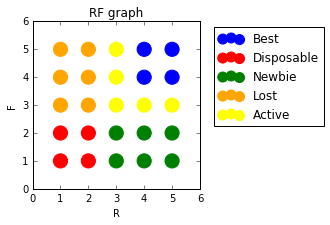

In [63]:
x = []
y = []
c = []
labels = []

for i in range(25):
    c1 = i / 5 + 1
    c2 = i % 5 + 1
    x.append(c1)
    y.append(c2)
    
    if c1 >= 4 and c2 >= 4:
        c.append("blue")
    elif c1 <= 2 and c2 <= 2:
        c.append("red")
    elif c1 >= 3 and c2 <= 2:
        c.append("green")
    elif c1 <= 2 and c2 >= 3:
        c.append("orange")
    else:
        c.append("yellow")
    
pl.figure(figsize=(3,3))
pl.scatter(1, 1, color = "blue", s = 100, label = "Best")
pl.scatter(1, 1, color = "red", s = 100, label = "Disposable")
pl.scatter(1, 1, color = "green", s = 100, label = "Newbie")
pl.scatter(1, 1, color = "orange", s = 100, label = "Lost")
pl.scatter(1, 1, color = "yellow", s = 100, label = "Active")
pl.scatter(x, y, color = c, s = 200)
pl.legend(loc = 2, bbox_to_anchor=(1.05, 1))

pl.ylabel("F")
pl.xlabel("R")
pl.title("RF graph")

pl.show()

In [64]:
def RSegmentation(x, q):
    if x <= q["recency"][0.2]:
        return 5
    elif x <= q["recency"][0.4]:
        return 4
    elif x <= q["recency"][0.6]:
        return 3
    elif x <= q["recency"][0.8]:
        return 2
    else:
        return 1
    
def FSegmentation(x, q):
    if x <= q["frequency"][0.2]:
        return 1
    elif x <= q["frequency"][0.4]:
        return 2
    elif x <= q["frequency"][0.6]:
        return 3
    elif x <= q["frequency"][0.8]:
        return 4
    else:
        return 5
    
def MSegmentation(x, q):
    if x <= q["money"][0.2]:
        return 1
    elif x <= q["money"][0.4]:
        return 2
    elif x <= q["money"][0.6]:
        return 3
    elif x <= q["money"][0.8]:
        return 4
    else:
        return 5

Распределим всех пользователей по классам

In [65]:
rfm["RClass"] = rfm["recency"].apply(RSegmentation, args=(quantiles,))
rfm["FClass"] = rfm["frequency"].apply(FSegmentation, args=(quantiles,))
rfm["MClass"] = rfm["money"].apply(MSegmentation, args=(quantiles,))
rfm.head()

,money,frequency,recency,RClass,FClass,MClass
user_id,,,,,,
00002ad98ae4290672431d702c211b4a,0.0,1,98,3,1,1
00003cb9076039f584a12c2036fd3602,0.0,19,26,5,5,1
000065938a8c02438551bef260a5ded0,0.0,7,284,1,3,1
000098543e00d361552ab956ec525772,0.0,1,189,2,1,1
0000d4b93e501f038977d4ae8fb7693b,0.0,2,61,4,2,1


Будем считать доли пользователей разных классов (из графика RF)

Сначала - доля и количество "лучших" пользователей

In [110]:
Best = rfm[(rfm["RClass"] >= 4) & (rfm["FClass"] >= 4)]

print round(len(Best) / float(n_users), 2)
print len(Best)

0.17
51945


"Новички"

In [111]:
Newbie = rfm[(rfm["RClass"] >= 3) & (rfm["FClass"] <= 2)]

print round(len(Newbie) / float(n_users), 2)
print len(Newbie)

0.24
72281


"Потерянные"

In [112]:
Lost = rfm[(rfm["RClass"] <= 2) & (rfm["FClass"] >= 3)]

print round(len(Lost) / float(n_users), 2)
print len(Lost)

0.19
57889


"Одноразовые"

In [113]:
Disposable = rfm[(rfm["RClass"] <= 2) & (rfm["FClass"] <= 2)]

print round(len(Disposable) / float(n_users), 2)
print len(Disposable)

0.21
61558


"Активные"

In [114]:
Active = rfm[(rfm["RClass"] == 3) & (rfm["FClass"] >= 3)] + rfm[(rfm["RClass"] >= 3) & (rfm["FClass"] == 3)]

print round(len(Active) / float(n_users), 2)
print len(Active)

0.19
55535


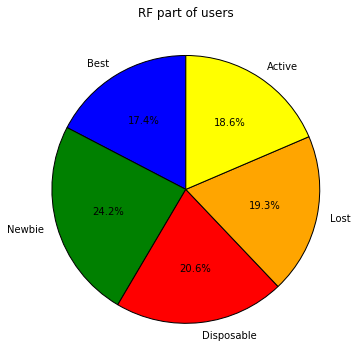

In [115]:
pl.figure(figsize=(6, 6))
pl.pie([len(Best), len(Newbie), len(Disposable), len(Lost), len(Active)],
       colors=["blue", "green", "red", "orange", "yellow"], 
       labels=["Best", "Newbie", "Disposable", "Lost", "Active"], startangle=90, autopct='%1.1f%%')
pl.title("RF part of users")
pl.show()

Суммарная выручка:

In [116]:
total_revenue = rfm["money"].sum()
total_revenue

10256466.0

Максимальный LTV:

In [117]:
rfm["money"].max()

37020.0

Пользователи с RFM - 555:

In [74]:
round(len(rfm[(rfm["RClass"] == 5) & (rfm["FClass"] == 5) & (rfm["MClass"] == 5)])/float(n_users), 3)

0.015

Пользователи с RFM - 551 (только смотрят)

In [75]:
round(len(rfm[(rfm["RClass"] == 5) & (rfm["FClass"] == 5) & (rfm["MClass"] == 1)])/float(n_users), 3)

0.016

Посмотрим на то, как распределилась выручка между классами

In [118]:
Best_revenue = Best["money"].sum()
Newbie_revenue = Newbie["money"].sum()
Disposable_revenue = Disposable["money"].sum()
Lost_revenue = Lost["money"].sum()
Active_revenue = Active["money"].sum()

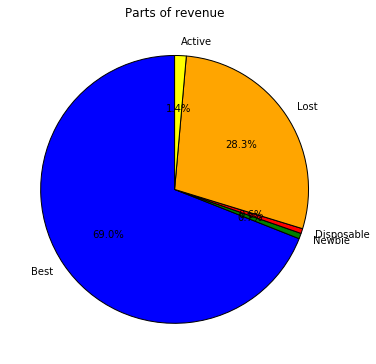

In [77]:
pl.figure(figsize=(6, 6))
pl.pie([Best_revenue, Newbie_revenue, Disposable_revenue, Lost_revenue, Active_revenue],
       colors=["blue", "green", "red", "orange", "yellow"], 
       labels=["Best", "Newbie", "Disposable", "Lost", "Active"], startangle=90, autopct='%1.1f%%')
pl.title("Parts of revenue")
pl.show()

Посмотрим на то, как распределились клики между классами

In [78]:
Best_frequency = Best["frequency"].sum()
Newbie_frequency = Newbie["frequency"].sum()
Disposable_frequency = Disposable["frequency"].sum()
Lost_frequency = Lost["frequency"].sum()
Active_frequency = Active["frequency"].sum()

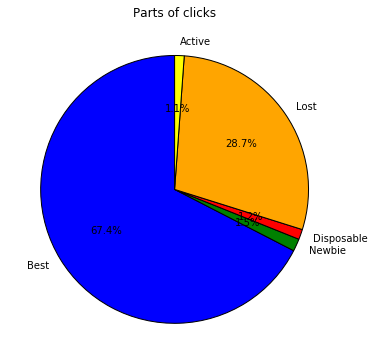

In [79]:
pl.figure(figsize=(6, 6))
pl.pie([Best_frequency, Newbie_frequency, Disposable_frequency, Lost_frequency, Active_frequency],
       colors=["blue", "green", "red", "orange", "yellow"], 
       labels=["Best", "Newbie", "Disposable", "Lost", "Active"], startangle=90, autopct='%1.1f%%')
pl.title("Parts of clicks")
pl.show()

Посмотрим на важный показатель - средний LTV по классу

In [80]:
Best_ltv = Best_revenue / float(len(Best))
Newbie_ltv = Newbie_revenue / float(len(Newbie))
Disposable_ltv = Disposable_revenue / float(len(Disposable))
Lost_ltv = Lost_revenue / float(len(Lost))
Active_ltv = Active_revenue / float(len(Active))

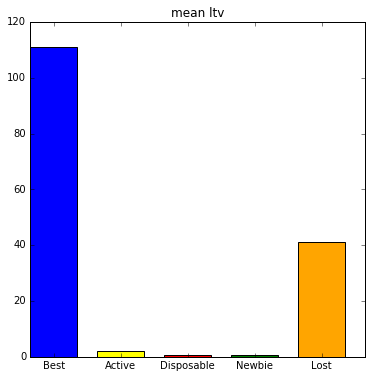

In [82]:
x_labels = ["Best", "Active", "Disposable", "Newbie", "Lost"]
x = range(5)
y = [Best_ltv, Active_ltv, Disposable_ltv, Newbie_ltv, Lost_ltv]

pl.figure(figsize=(6,6))
pl.bar(x, y, width = 0.7, color = ["blue", "yellow", "red", "green", "orange"])
pl.xticks([i + 0.35 for i in x],x_labels)
pl.title("mean ltv")
pl.show()

In [46]:
print Best_frequency
print Newbie_frequency
print Disposable_frequency 
print Lost_frequency
print Active_frequency

5403019
119961
97866
2299482
92076.0


In [119]:
Best_len = len(Best)
Newbie_len = len(Newbie)
Disposable_len = len(Disposable)
Lost_len = len(Lost)
Active_len = len(Active)

Как прирастет число кликов из-за push-уведомлений?

In [85]:
mark = 0.52*0.15
Best_frequency_inc = len(Best) * mark
print Best_frequency_inc, Best_frequency_inc / float(Best_frequency)

Newbie_frequency_inc = len(Newbie) * mark
print Newbie_frequency_inc, Newbie_frequency_inc / float(Newbie_frequency)

Disposable_frequency_inc = len(Disposable) * mark
print Disposable_frequency_inc, Disposable_frequency_inc / float(Disposable_frequency)

Lost_frequency_inc = len(Lost) * mark
print Lost_frequency_inc, Lost_frequency_inc / float(Lost_frequency)

Active_frequency_inc = len(Active) * mark
print Active_frequency_inc, Active_frequency_inc / float(Active_frequency)

4051.71 0.000749897418462
5637.918 0.0469979243254
4801.524 0.0490622279443
4515.342 0.00196363441853
4331.73 0.0470451583475


Добавим к исходной базе дополнительный параметр каждого клика - класс пользователя

In [97]:
data = pd.read_csv("rfm.tsv", quoting=csv.QUOTE_NONE, sep="\t",
                   names=["timestamp", "user_id", "url or click", "geo_id", "category", "price"])

In [98]:
best_index = set(Best.index)
newbie_index = set(Newbie.index)
disposable_index = set(Disposable.index)
lost_index = set(Lost.index)
active_index = set(Active.index)

In [99]:
def division(user_id):
    if user_id in best_index:
        return "Best"
    if user_id in newbie_index:
        return"Newbie"
    if user_id in disposable_index:
        return "Disposable"
    if user_id in lost_index:
        return "Lost"

    return "Active"


data["Class"] = data.apply(lambda row: division(row["user_id"]), axis = 1)

data.head()

,timestamp,user_id,url or click,geo_id,category,price,Class
0,1380052543,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,NaN,NaN,Newbie
1,1375703582,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,NaN,NaN,Best
2,1374479873,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN,Best
3,1374479892,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN,Best
4,1374480337,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN,Best


Разделим клики на платные(click_type = 1), просмотры отзывов(click_type = 2), переходы на карточки товаров(click_type = 3) и на все осталбные(click_type = 0)

In [100]:
def url_division(url):
    if url == "click":
        return 1 #платные клики
    if "review" in url or "opinion" in url:
        return 2 #просмотр отзывов
    if "model.xml" in url:
        return 3 #карточка товара
    return 0

data["click_type"] = data.apply(lambda row: url_division(row["url or click"]), axis = 1)
data.tail()

,timestamp,user_id,url or click,geo_id,category,price,Class,click_type
10007142,1361889766,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,213,4165204,NaN,Lost,0
10007143,1361889775,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=8464553&hid=4165204&how=ap...,213,4165204,NaN,Lost,0
10007144,1361889674,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981213&hid=294661&hyperid=...,213,294661,NaN,Lost,0
10007145,1361889363,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,213,91033,NaN,Lost,0
10007146,1361889367,fffffdbc5c7fbe34b444d9c213bba286,/offers.xml?modelid=981770&hid=91033&how=aprice,213,91033,NaN,Lost,0


Какая доля кликов ведет к отзывам?

In [101]:
len(data[data["click_type"] == 2]) / float(n_clicks)

0.11540971667549202

Какая доля кликов ведет в магазины?

In [102]:
len(data[data["click_type"] == 1]) / float(n_clicks)

0.036305352564522136

Какие самые регионы самые активные?

10000 - универсальный код
213 - Москва
2 - Санкт-Петербург
47 - Нижний Новгород
39 - Ростов-на-Дону
54 - Екатеринбург

In [103]:
geo_counter = Counter(data["geo_id"])
geo_counter.most_common(7)

[(10000, 6014215),
 (213, 1809348),
 (2, 294418),
 (54, 90230),
 (47, 88506),
 ('10000', 82715),
 (39, 81938)]

Какие категории самые популярные?

91491 - Мобильные телефоны
6427100 - Планшеты
91013 - Ноутбуки
90639 - Телевизоры

In [104]:
categories_counter = Counter(data["category"])
categories_counter.most_common(5)

[(nan, 4449354),
 ('91491', 1113146),
 ('6427100', 361359),
 ('91013', 255239),
 ('90639', 255200)]

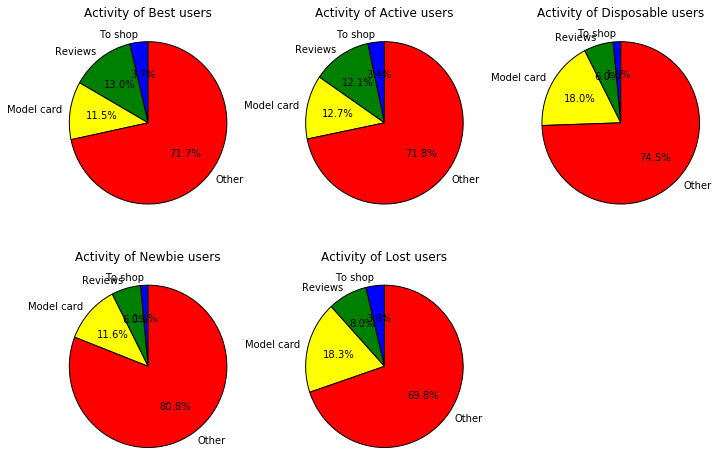

In [120]:
Best = data[data["Class"] == "Best"]
Active = data[data["Class"] == "Active"]
Disposable = data[data["Class"] == "Disposable"]
Newbie = data[data["Class"] == "Newbie"]
Lost = data[data["Class"] == "Lost"]

pl.figure(figsize=(12, 8))

pl.subplot(2, 3, 1)
pl.pie([len(Best[Best["click_type"] == 1]), len(Best[Best["click_type"] == 2]), 
        len(Best[Best["click_type"] == 3]), len(Best[Best["click_type"] == 0])],
       colors=["blue", "green", "yellow", "red"], 
       labels=["To shop", "Reviews", "Model card", "Other"], startangle=90, autopct='%1.1f%%')
pl.title("Activity of Best users")

pl.subplot(2, 3, 2)
pl.pie([len(Active[Active["click_type"] == 1]), len(Active[Active["click_type"] == 2]),
        len(Active[Active["click_type"] == 3]), len(Active[Active["click_type"] == 0])],
       colors=["blue", "green", "yellow", "red"], 
       labels=["To shop", "Reviews", "Model card", "Other"], startangle=90, autopct='%1.1f%%')
pl.title("Activity of Active users")

pl.subplot(2, 3, 3)
pl.pie([len(Disposable[Disposable["click_type"] == 1]), len(Disposable[Disposable["click_type"] == 2]),
        len(Disposable[Disposable["click_type"] == 3]), len(Disposable[Disposable["click_type"] == 0])],
       colors=["blue", "green", "yellow", "red"], 
       labels=["To shop", "Reviews", "Model card", "Other"], startangle=90, autopct='%1.1f%%')
pl.title("Activity of Disposable users")

pl.subplot(2, 3, 4)
pl.pie([len(Newbie[Newbie["click_type"] == 1]), len(Newbie[Newbie["click_type"] == 2]), 
        len(Newbie[Newbie["click_type"] == 3]), len(Newbie[Newbie["click_type"] == 0])],
       colors=["blue", "green", "yellow", "red"], 
       labels=["To shop", "Reviews", "Model card", "Other"], startangle=90, autopct='%1.1f%%')
pl.title("Activity of Newbie users")

pl.subplot(2, 3, 5)
pl.pie([len(Lost[Lost["click_type"] == 1]), len(Lost[Lost["click_type"] == 2]), 
        len(Lost[Lost["click_type"] == 3]), len(Lost[Lost["click_type"] == 0])],
       colors=["blue", "green", "yellow", "red"], 
       labels=["To shop", "Reviews", "Model card", "Other"], startangle=90, autopct='%1.1f%%')
pl.title("Activity of Lost users")

pl.show()

Больше всего читают отзывы "Лучшие" пользователи.

В магазины примерно поровну переходят как "Лучшие", так и "Потерянные".

На карточку товара больше всего смотрят "Потерянные".

Сравнение отношения числа платных кликов к просмотрам карточки товара

In [106]:
Best_mark = len(Best[Best["click_type"] == 1]) / float(len(Best[Best["click_type"] == 3]))
Active_mark = len(Active[Active["click_type"] == 1]) / float(len(Active[Active["click_type"] == 3]))
Disposable_mark = len(Disposable[Disposable["click_type"] == 1]) / float(len(Disposable[Disposable["click_type"] == 3]))
Newbie_mark = len(Newbie[Newbie["click_type"] == 1]) / float(len(Newbie[Newbie["click_type"] == 3]))
Lost_mark = len(Lost[Lost["click_type"] == 1]) / float(len(Lost[Lost["click_type"] == 3]))

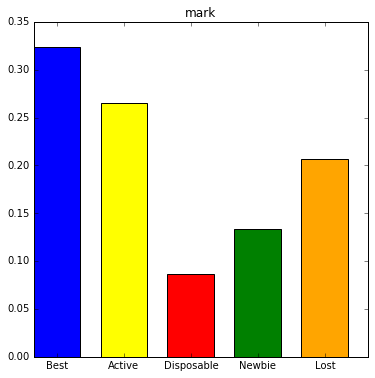

In [107]:
x_labels = ["Best", "Active", "Disposable", "Newbie", "Lost"]
x = range(5)
y = [Best_mark, Active_mark, Disposable_mark, Newbie_mark, Lost_mark]

pl.figure(figsize=(6,6))
pl.bar(x, y, width = 0.7, color = ["blue", "yellow", "red", "green", "orange"])
pl.xticks([i + 0.35 for i in x],x_labels)
pl.title("mark")
pl.show()

Как вырастет количество платных кликов?

In [108]:
Best_paid_inc = (len(Best[Best["click_type"] == 3]) + Best_frequency_inc) * Best_mark - len(Best[Best["click_type"] == 1])
Active_paid_inc = (len(Active[Active["click_type"] == 3]) + Active_frequency_inc) * Active_mark - len(Active[Active["click_type"] == 1])
Disposable_paid_inc = (len(Disposable[Disposable["click_type"] == 3]) + Disposable_frequency_inc) * Disposable_mark - len(Disposable[Disposable["click_type"] == 1])
Newbie_paid_inc = (len(Newbie[Newbie["click_type"] == 3]) + Newbie_frequency_inc) * Newbie_mark - len(Newbie[Newbie["click_type"] == 1])
Lost_paid_inc = (len(Lost[Lost["click_type"] == 3]) + Lost_frequency_inc) * Lost_mark - len(Lost[Lost["click_type"] == 1])

In [109]:
print Best_paid_inc
print Active_paid_inc
print Disposable_paid_inc
print Newbie_paid_inc
print Lost_paid_inc

1312.96116239
1150.8070669
415.611086046
751.641534854
932.54513693


На какую долю вырастет средний LTV пользователя?

In [129]:
print (Best_revenue / float(len(Best[Best["click_type"] == 1]))) * Best_paid_inc / (Best_len * Best_ltv)
print (Active_revenue / float(len(Active[Active["click_type"] == 1]))) * Active_paid_inc / (Active_len * Active_ltv)
print (Disposable_revenue / float(len(Disposable[Disposable["click_type"] == 1]))) * Disposable_paid_inc / (Disposable_len * Disposable_ltv)
print (Newbie_revenue / float(len(Newbie[Newbie["click_type"] == 1]))) * Newbie_paid_inc / (Newbie_len * Newbie_ltv)
print (Lost_revenue / float(len(Lost[Lost["click_type"] == 1]))) * Lost_paid_inc / (Lost_len * Lost_ltv)

0.0064928648692
0.0163013069706
0.273248577282
0.404325731497
0.0107040224163
